In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
test = pd.read_csv('C:/Users/user/github/Data/aifactory/test_data.csv')
train = pd.read_csv('C:/Users/user/github/Data/aifactory/train_data.csv')


In [99]:
from sklearn.preprocessing import StandardScaler

In [101]:
st = StandardScaler()

In [3]:
train.type.unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [4]:
train = train.drop('out_pressure', axis=1)

In [5]:
test = test.drop('out_pressure',axis=1)

In [102]:
st.fit(train)

StandardScaler()

In [103]:
st.fit_transform(test)

array([[ 0.34956982,  0.48784827,  0.38706193, ...,  0.49197811,
         0.20876468, -1.32637639],
       [ 0.47844475,  0.71350861,  0.53139596, ...,  0.71675676,
         0.34848248, -1.32637639],
       [-0.32917145, -0.7256517 , -0.39203953, ..., -0.71846784,
        -0.52087275, -1.32637639],
       ...,
       [-0.46663804, -0.97088462, -0.54922004, ..., -0.96262396,
        -0.66059055,  1.81311501],
       [-0.44086306, -0.92713414, -0.52126004, ..., -0.91870169,
        -0.64506635,  1.81311501],
       [-0.34635478, -0.75213225, -0.40866439, ..., -0.74430447,
        -0.53639695,  1.81311501]])

In [6]:
train_x_1 = train[(train['type']==0) | (train['type']==4)| (train['type']==5) | (train['type']==6) | (train['type']==7)].values

In [7]:
train_x_2 = train[train['type'] == 1].values

In [8]:
train_x_3 = train[train['type'] == 2].values

In [9]:
train_x_4 = train[train['type'] == 3].values

In [10]:
test_x_1 = test[(test['type']==0) | (test['type']==4)| (test['type']==5) | (test['type']==6) | (test['type']==7)].values

In [11]:
test_x_2 = test[test['type'] == 1].values
test_x_3 = test[test['type'] == 2].values
test_x_4 = test[test['type'] == 3].values

In [12]:
from sklearn.decomposition import PCA

In [13]:
import sys
sys.path.append('C:/Users/User/github/Function/python/')
import eif as iso
import igraph as ig

def branch2num(branch, init_root=0):
    num = [init_root]
    for b in branch:
        if b == 'L':
            num.append(num[-1] * 2 + 1)
        if b == 'R':
            num.append(num[-1] * 2 + 2)
    return num

def gen_graph(branches, g = None, init_root = 0, pre = ''):
    num_branches = [branch2num(i, init_root) for i in branches]
    all_nodes = [j for branch in num_branches for j in branch]
    all_nodes = np.unique(all_nodes)
    all_nodes = all_nodes.tolist()
    if g is None:
        g=ig.Graph()
    for k in all_nodes : g.add_vertex(pre+str(k))
    t=[]
    for j in range(len(branches)):
        branch = branch2num(branches[j], init_root)
        for i in range(len(branch)-1):
            pair = [branch[i],branch[i+1]]
            if pair not in t:
                t.append(pair)
                g.add_edge(pre+str(branch[i]),pre+str(branch[i+1]))
    return g,max(all_nodes)

In [14]:
clf_1 = iso.iForest(train_x_1, sample_size=256, ntrees=500, limit=12, ExtensionLevel=1)
clf_2 = iso.iForest(train_x_2, sample_size=256, ntrees=500, limit=12, ExtensionLevel=1)
clf_3 = iso.iForest(train_x_3, sample_size=256, ntrees=500, limit=12, ExtensionLevel=1)
clf_4 = iso.iForest(train_x_4, sample_size=256, ntrees=500, limit=12, ExtensionLevel=1)

In [15]:
S0 = clf_1.compute_paths(X_in=test_x_1)
S1 = clf_2.compute_paths(X_in=test_x_2)
S2 = clf_3.compute_paths(X_in=test_x_3)
S3 = clf_4.compute_paths(X_in=test_x_4)

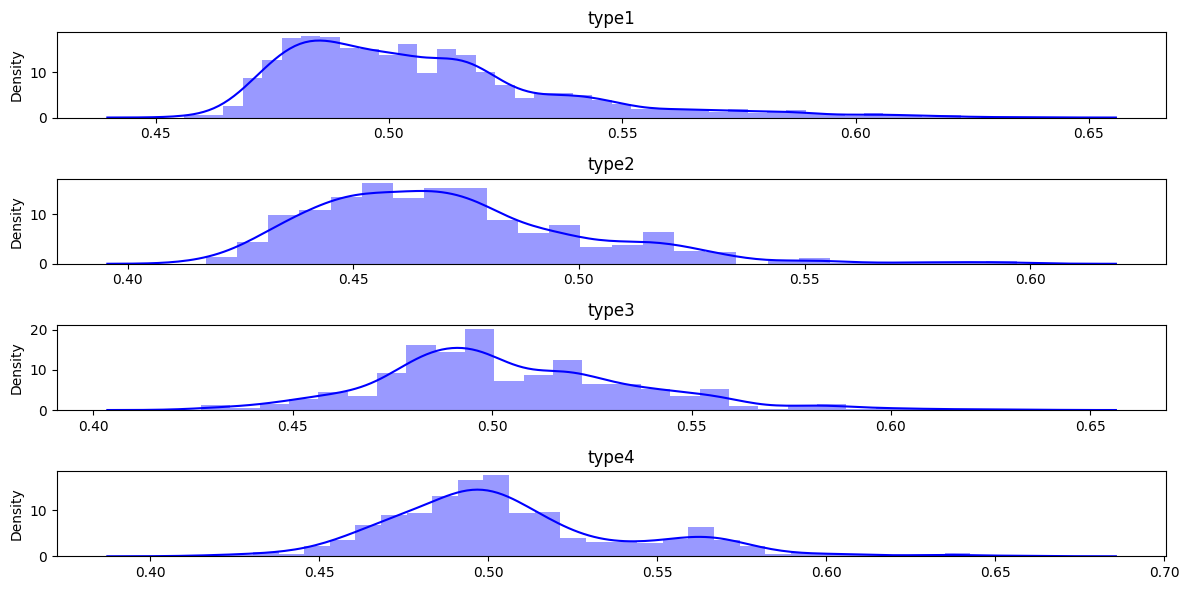

In [16]:
f = plt.figure(figsize=(12,6))

plt.subplot(4,1,1)
sns.distplot(S0, kde=True, color="b")
plt.title('type1')

plt.subplot(4,1,2)
sns.distplot(S1, kde=True, color="b")
plt.title('type2')

plt.subplot(4,1,3)
sns.distplot(S2, kde=True, color="b")
plt.title('type3')

plt.subplot(4,1,4)
sns.distplot(S3, kde=True, color="b")
plt.title('type4')

plt.tight_layout()
plt.show()

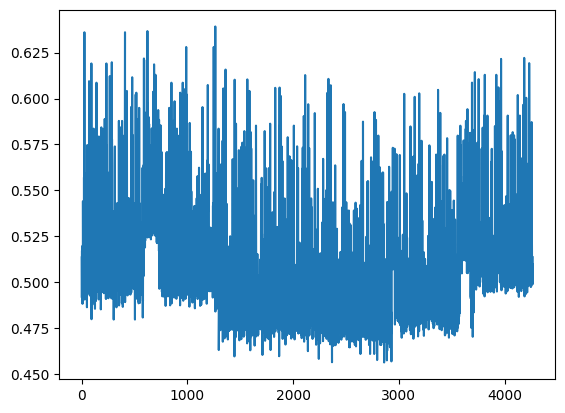

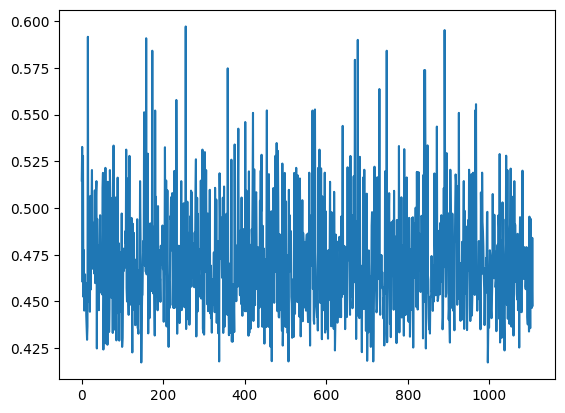

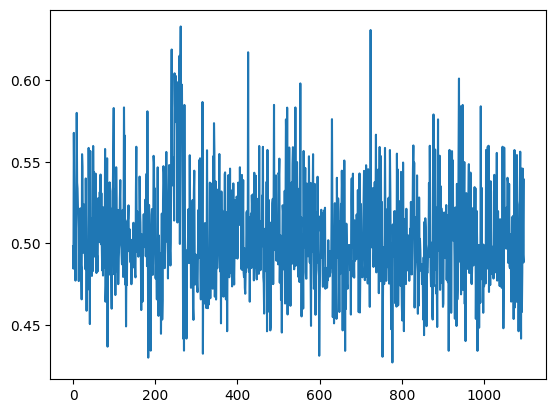

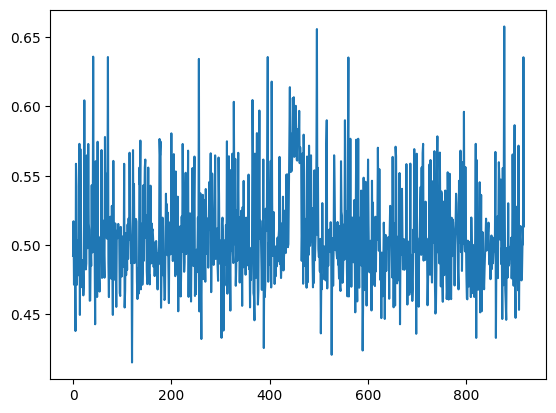

In [17]:
plt.plot(S0)
plt.show()
plt.plot(S1)
plt.show()
plt.plot(S2)
plt.show()
plt.plot(S3)
plt.show()

In [18]:
from sklearn.mixture import GaussianMixture

# GMM: n_components = 모델의 총 수
gm_1 = GaussianMixture(n_components=4, covariance_type = 'full',n_init=30, random_state=42)
gm_1.fit(train)

GaussianMixture(n_components=4, n_init=30, random_state=42)

In [19]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=4, n_init=15, random_state=42)
bgm.fit(train)
np.round(bgm.weights_, 2)

array([0.58, 0.29, 0.12, 0.01])

In [20]:
print(gm_1.converged_)
print(bgm.converged_)

True
True


test = test.drop('label', axis=1)

In [21]:
gm_1.predict(test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [22]:
densities = gm_1.score_samples(test)
density_threshold = np.percentile(densities, 4)

In [23]:
bgm_densities = bgm.score_samples(test)
bgm_density_threshold = np.percentile(bgm_densities, 2)
bgm_anomalies = test[bgm_densities < bgm_density_threshold]

In [24]:
print(density_threshold)
print(bgm_density_threshold)

-56446.90450995895
-1592.7521038903644


Text(0.5, 1.0, 'gmm result')

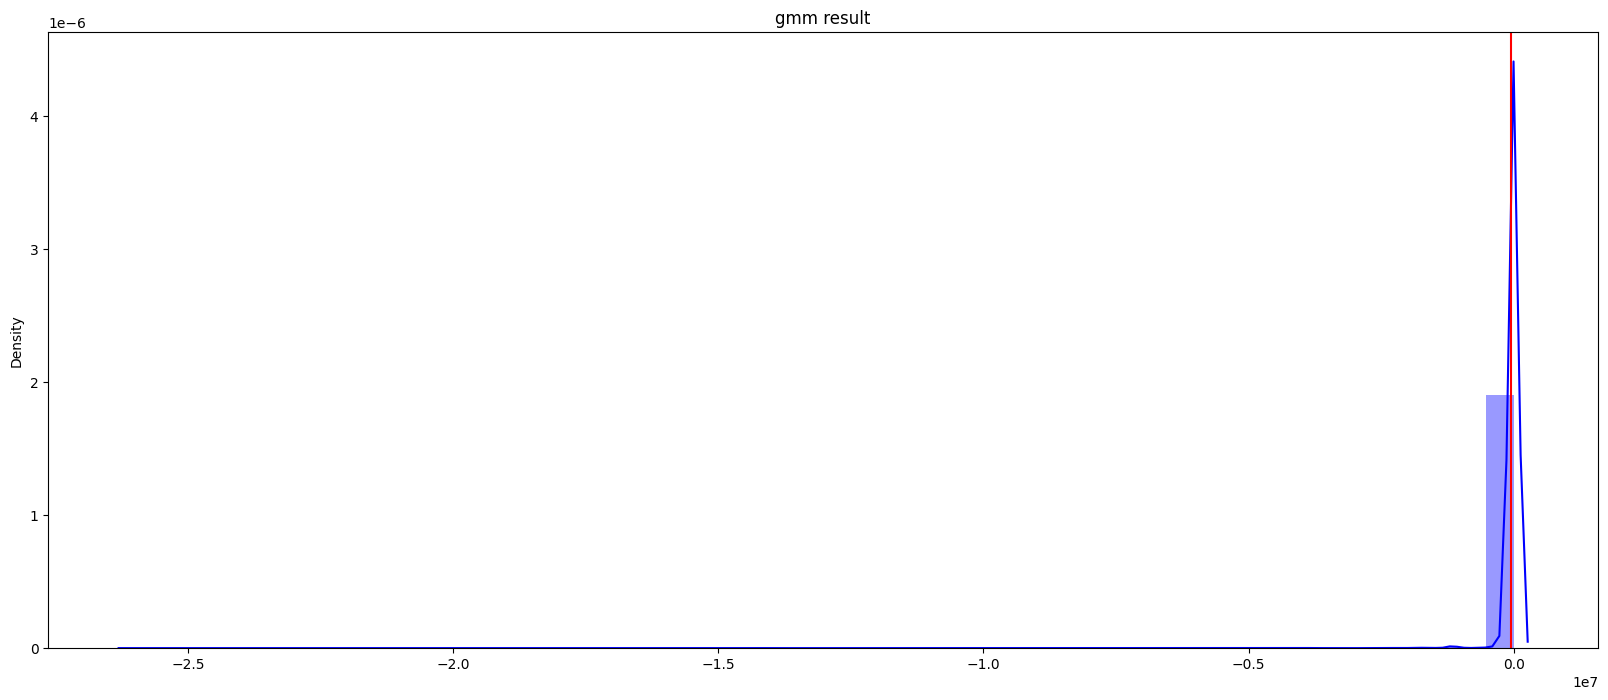

In [25]:
plt.figure(figsize=(20,8))
sns.distplot(densities, kde=True, color="b")
plt.axvline(density_threshold, color = 'red')
plt.title('gmm result')

Text(0.5, 1.0, 'bgm result')

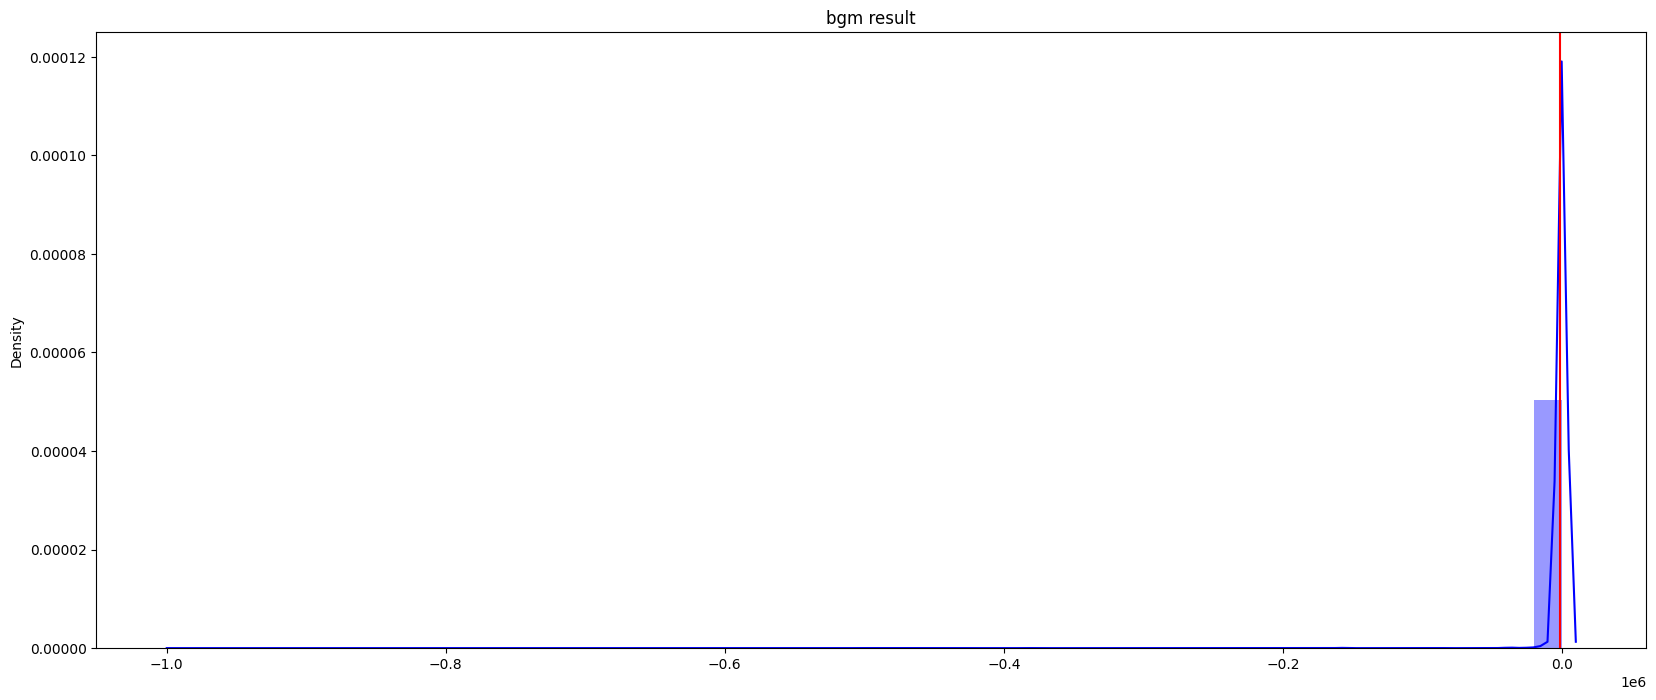

In [26]:
plt.figure(figsize=(20,8))
sns.distplot(bgm_densities, kde=True, color="b")
plt.axvline(bgm_density_threshold, color = 'red')
plt.title('bgm result')

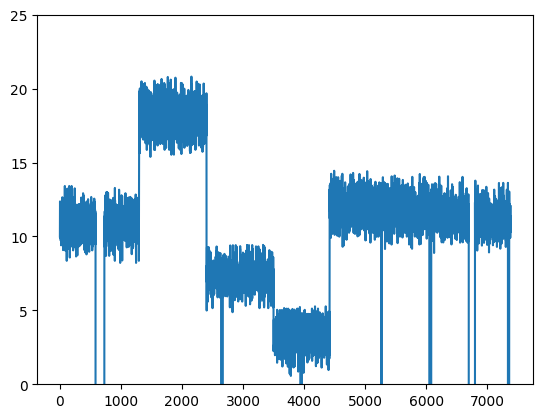

In [27]:
plt.plot(densities)
plt.axhline(density_threshold, color = 'r')
plt.ylim(0,25)
plt.show()

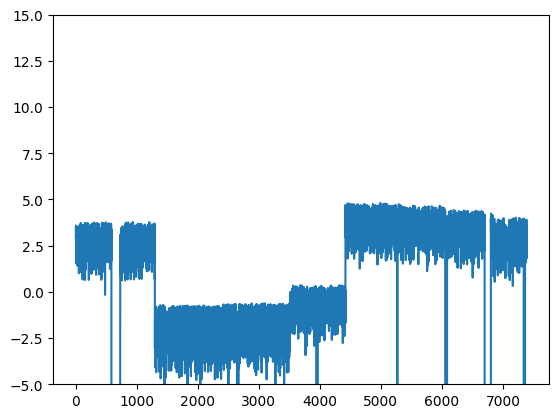

In [28]:
plt.plot(bgm_densities)
plt.axhline(bgm_density_threshold, color = 'r')
plt.ylim(-5,15)
plt.show()

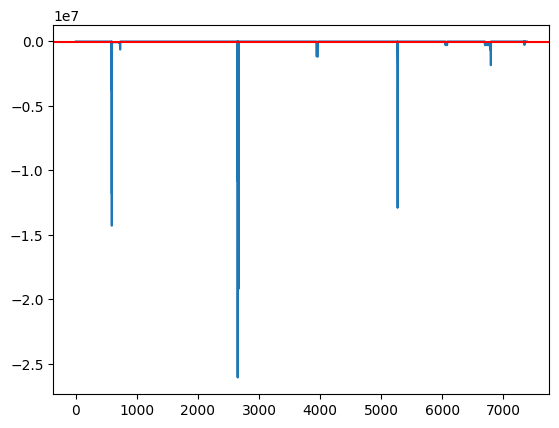

In [29]:
plt.plot(densities)
plt.axhline(density_threshold, color = 'r')


In [30]:
anomalies = test[densities < density_threshold]

In [105]:
bgm_anomalies = test[bgm_densities < bgm_density_threshold]

In [106]:
anomalies

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
586,2.06,51.95,31.64,2476.0,59.34,3.58,0
587,1.35,41.20,20.65,1616.0,60.34,3.10,0
588,2.86,63.93,43.88,3434.0,61.34,4.11,0
590,2.89,64.34,44.30,3467.0,63.34,4.13,0
591,1.21,39.08,18.48,1446.0,64.34,3.00,0
...,...,...,...,...,...,...,...
6800,1.44,50.90,27.05,2072.0,63.02,3.55,6
7342,1.60,45.04,24.57,1923.0,61.37,3.27,7
7348,2.76,62.36,42.28,3309.0,76.77,4.04,7
7359,1.48,43.15,22.64,1772.0,59.69,3.18,7


In [107]:
bgm_anomalies

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
586,2.06,51.95,31.64,2476.0,59.34,3.58,0
587,1.35,41.20,20.65,1616.0,60.34,3.10,0
588,2.86,63.93,43.88,3434.0,61.34,4.11,0
590,2.89,64.34,44.30,3467.0,63.34,4.13,0
591,1.21,39.08,18.48,1446.0,64.34,3.00,0
...,...,...,...,...,...,...,...
6797,1.57,53.23,29.48,2258.0,65.09,3.65,6
6798,1.83,57.98,34.44,2638.0,69.31,3.87,6
6799,1.99,60.84,37.43,2867.0,71.86,3.99,6
6800,1.44,50.90,27.05,2072.0,63.02,3.55,6


In [108]:
test.index

RangeIndex(start=0, stop=7389, step=1)

In [109]:
result = pd.DataFrame(index = test.index ,columns=['gm','bgm','hotelling'], data=0)

In [110]:
result.loc[anomalies.index.tolist(), 'gm'] = 1

In [111]:
result.loc[bgm_anomalies.index.tolist(), 'bgm'] = 1

test.to_csv('C:/Users/user/Desktop/a.csv', index=False)

In [112]:
import numpy as np

def hotellings_tsquare(trdat, tedat):
    '''
    Hotellings T-square : 공분산을 반영한 유클리디안 거리 (마할라노비스 거리)
    
    @param trdat : train data
    @param tedat : test data
    '''
    obs = trdat.shape[0]
    dim = trdat.shape[1]
    
    mu = trdat.apply(np.mean, axis=0) # 열단위 평균계산
    sinv = np.linalg.pinv(trdat.cov()) # 공분산 역행렬

    dte = (tedat-mu).values 
    
    Tsq_mat = np.zeros(tedat.shape[0])
    for i in range(tedat.shape[0]):
        Tsq_mat[i] = dte[i,:] @ sinv @ dte[i,:].transpose() # t-square distance
        
    return Tsq_mat

def bootstrap_limit(stat, alpha=0.05, bootstrap=100):
    '''
    Bootstrap sampling을 활용한 Control Limit 산출 기법
    
    @param stat : 통계량
    @param alpha : Control Limit을 정하기 위한 유의수준
    @param : bootstrap : 샘플링 횟수
    '''
    alpha = (alpha/2)*100
    alpha = 100 - alpha
    samsize = max(10000, len(stat))
    limit = np.mean(list(map(lambda x:np.percentile(np.random.choice(stat,samsize,replace=True),alpha), range(0,bootstrap))))
    # stat에서 samsize만큼 선택 후 75%분위수(alpha에따라 변경) 뽑기 이후 bootstrap만큼 반복 후 리스트로 만들고 평균 계산
    return limit

In [113]:
train_x_1 = train[(train['type']==0) | (train['type']==4)| (train['type']==5) | (train['type']==6) | (train['type']==7)]
train_x_2 = train[train['type'] == 1]
train_x_3 = train[train['type'] == 2]
train_x_4 = train[train['type'] == 3]

In [114]:
test_x_1 = test[(test['type']==0) | (test['type']==4)| (test['type']==5) | (test['type']==6) | (test['type']==7)]
test_x_2 = test[test['type'] == 1]
test_x_3 = test[test['type'] == 2]
test_x_4 = test[test['type'] == 3]

In [115]:
hotellings_1 = hotellings_tsquare(pd.DataFrame(train_x_1), pd.DataFrame(train_x_1))
hotellings_2 = hotellings_tsquare(pd.DataFrame(train_x_2), pd.DataFrame(train_x_2))
hotellings_3 = hotellings_tsquare(pd.DataFrame(train_x_3), pd.DataFrame(train_x_3))
hotellings_4 = hotellings_tsquare(pd.DataFrame(train_x_4), pd.DataFrame(train_x_4))


In [116]:
hotellings_1_all = hotellings_tsquare(pd.DataFrame(train_x_1), pd.DataFrame(test_x_1))
hotellings_2_all = hotellings_tsquare(pd.DataFrame(train_x_2), pd.DataFrame(test_x_2))
hotellings_3_all = hotellings_tsquare(pd.DataFrame(train_x_3), pd.DataFrame(test_x_3))
hotellings_4_all = hotellings_tsquare(pd.DataFrame(train_x_4), pd.DataFrame(test_x_4))


(0.0, 70.0)

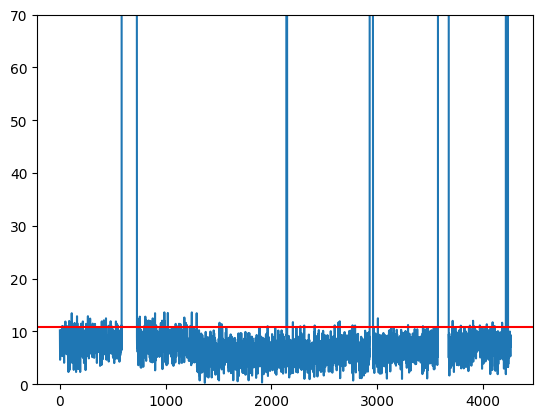

In [117]:
plt.plot(hotellings_1_all)
plt.axhline(y = bootstrap_limit(hotellings_1), color = 'r')
plt.ylim(0,70)

(0.0, 70.0)

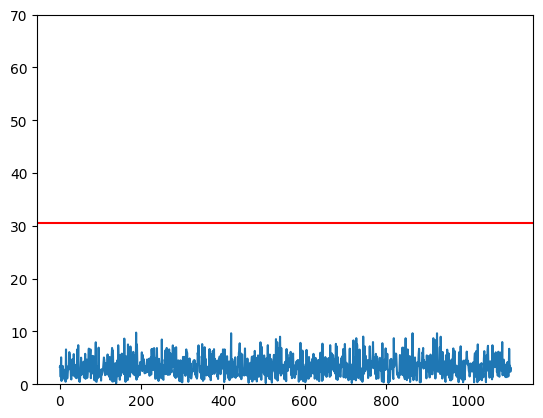

In [118]:
plt.plot(hotellings_2_all)
plt.axhline(y = bootstrap_limit(hotellings_2), color = 'r')
plt.ylim(0,70)

(0.0, 70.0)

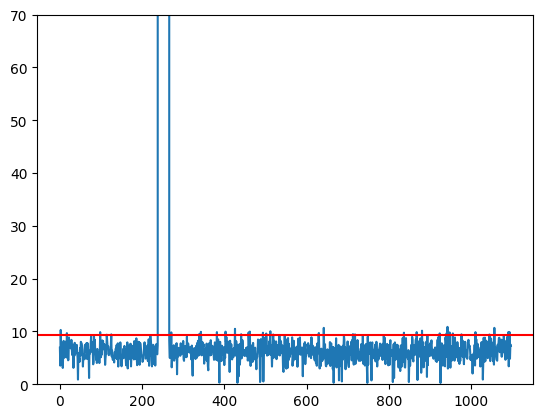

In [119]:
plt.plot(hotellings_3_all)
plt.axhline(y = bootstrap_limit(hotellings_3), color = 'r')
plt.ylim(0,70)

(0.0, 70.0)

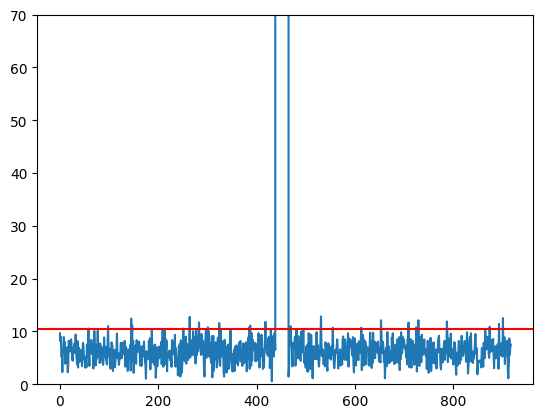

In [120]:
plt.plot(hotellings_4_all)
plt.axhline(y = bootstrap_limit(hotellings_4), color = 'r')
plt.ylim(0,70)

In [121]:
hotellings_1_anomalies = test_x_1[hotellings_1_all > bootstrap_limit(hotellings_1)]
hotellings_2_anomalies = test_x_2[hotellings_2_all > bootstrap_limit(hotellings_2)]
hotellings_3_anomalies = test_x_3[hotellings_3_all > bootstrap_limit(hotellings_3)]
hotellings_4_anomalies = test_x_4[hotellings_4_all > bootstrap_limit(hotellings_4)]

In [122]:
result.loc[hotellings_1_anomalies.index.tolist(), 'hotelling'] = 1
result.loc[hotellings_2_anomalies.index.tolist(), 'hotelling'] = 1
result.loc[hotellings_3_anomalies.index.tolist(), 'hotelling'] = 1
result.loc[hotellings_4_anomalies.index.tolist(), 'hotelling'] = 1

In [123]:
result['label'] = result.mean(axis=1)

In [124]:
result.label[0]

0.0

In [125]:
for i in range(len(result)):
    if result.label[i] > 0.5:
        result.label[i] = 1
    else:
        result.label[i] = 0

<Axes: >

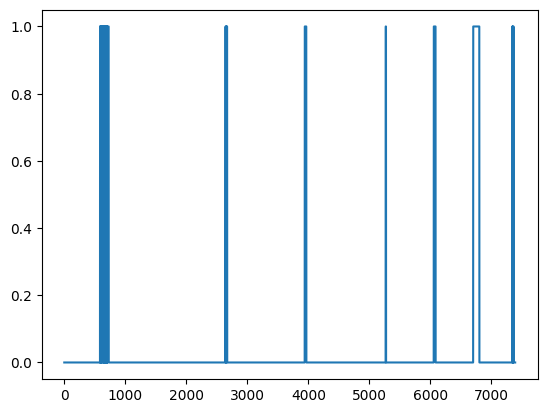

In [126]:
result.label.plot()

result.to_csv('C:/Users/user/Desktop/result.csv', index=False)